In [8]:
import numpy as np
from scipy.linalg import sqrtm
from scipy import sparse
from scipy.sparse import linalg

In [9]:
def sample_entry(M, delta):
    
    for i in range(M.shape[1]):
        sample = np.random.choice(2, M.shape[0], p=[1 - delta, delta])
        M[:, i] = M[:, i] * sample

    return M

In [10]:
def SPCA(C, k):
    omega = np.random.randn(C.shape[1], k)
    omega = sparse.csr_matrix(omega)
    
    #print ("gauss random matrix shape ", omega.shape)
    
    #_C = np.zeros(C.shape)
    
    _C = sparse.csr_matrix(C.shape)
    
    # Trimming
    for i in range (C.shape[0]):
        if ((C.getrow(i).count_nonzero()) > 10):
            _C[i,:] = 0
        else:
            _C[i,:] = C[i,:]
    
    #print ("_C shape ", _C.shape)
    
    diag_matrix = sparse.diags(diagonals=((_C.T @ _C).diagonal()), offsets=0, format="csr")
    
    F = _C.T @ _C - diag_matrix
    
    
    _power = int(np.ceil(5 * np.log(C.shape[1])))
    
    #print ("power ", _power)
    
    for i in range (_power):
        F = F @ F
        
    F = F @ omega

    
    #print ("F shape ", F.shape)
    #print ("k ", k)
    
    #QR = (np.linalg.matrix_power(F, 
    #                             int(np.ceil(5 * np.log(C.shape[1])))) @ omega)
    
    #print ("QR shape ", QR.shape)
    
    #Q, _ = np.linalg.qr(QR)
    
    u, _, _ = sparse.linalg.svds(F, k - 1)
    
    
    #return Q[:, :k]
    return u

In [11]:
def SLA(M, k, delta, l):
    
    M = M.astype(np.float64)
    
    m, n = M.shape[0], M.shape[1]
    #print ("k ", k)
    #print ("l ", l)
    #print ("M shape ", M.shape)
    
    #l_samples = list(np.random.choice(n, l, replace=True))
    l_samples = np.arange(l)
    
    #print ("sample len ", len(l_samples))
        
    A_b1 = sample_entry(M[:, l_samples], delta)
    A_b2 = sample_entry(M[:, l_samples], delta)
    
    A_b1 = sparse.csr_matrix(A_b1)
    A_b2 = sparse.csr_matrix(A_b2)
    
    #print("A_b1 shape ", A_b1.shape)

    
    Q = SPCA(A_b1, k + 1)
    #print("Q shape ", Q.shape)
    
    M = np.delete(M, l_samples, 1)
    
    for i in range(m):
        if ((A_b2.getrow(i).count_nonzero()) > 2):
            A_b2[i, :] = 0
            
    for i in range(l):
        if ((A_b2.getcol(i).count_nonzero()) > 10 * delta * m):
            A_b2[:, i] = 0
    
    #print ("A_b2 shape: ", A_b2.shape)
    
    W = A_b2 @ Q
    V = np.zeros((n, k))
    
    #print("W shape", W.shape)
    #print("V shape", V.shape)
    
    V[:l, :] = (A_b1).T @ W
    
    ## FIXME: ??? what size ???
    I = A_b1 @ V[:l, :]
    #print("I shape 1", I.shape)
    
    ### TODO: Need to remove A_b1, A_b2 and Q from RAM
    
    for t in range(l, n):
        A_t = M[:, t - l]
        V[t, :] = A_t.reshape(1, -1) @ W
        I += A_t.reshape(-1, 1) @ V[t, :].reshape(1, -1)
    
    #print("I shape 2", I.shape)
        ## TODO: remove A_t from RAM ???

    #print("rank A_b1:", np.linalg.matrix_rank(A_b1))
    #print("rank A_b2:", np.linalg.matrix_rank(A_b2))
    #print("rank W:", np.linalg.matrix_rank(W))
    #print("rank Q:", np.linalg.matrix_rank(Q))
    #print("rank V:", np.linalg.matrix_rank(V))
    #print("rank I:", np.linalg.matrix_rank(I))
    
    R = sqrtm(V.T @ V)
    R = np.linalg.inv(R)
    
    #print("R shape", R.shape)
    
    U = (1.0/delta) * (I @ R @ R.T)
    
    ## FIXME: Need to find out what is here in actual algorithm
    M_k = U @ V.T
    print(M_k.shape)
    
    filler = []
    
    for i in range(n-l-1, n-1):
        filler.append(M_k[:, i])
        filler.append(0.5 * (M_k[:, i] + M_k[:, i+1]))
    
    filler = np.array(filler).T
    print(filler.shape)
    print(M_k[:, n-l:].shape)
    
    M_k[:, :n-2*l] = M_k[:, l:n-l]
    M_k[:, n-2*l:] = filler
    
    return M_k      

In [12]:
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np

def load_sequence(path, start, stop):
    
    files = sorted(os.listdir(path))
    frame = Image.open(os.path.join(path, files[0]))
    frame = frame.convert("L")
    frame = np.array(frame) / 255.0
    
    print(frame.shape)
        
    frame_size = frame.shape
    size = frame.shape[0] * frame.shape[1]

    M = np.zeros((size, stop - start), np.float32)
    
    for i in range(start, stop):
        frame = Image.open(os.path.join(path, files[i])).convert("L")
        frame = np.array(frame)
        M[:, i] = frame.reshape(-1)
    
    return M, frame_size

videos = [
            "./videos/Bootstrap",
            "./videos/Camouflage",
            "./videos/ForegroundAperture",
            "./videos/LightSwitch",
            "./videos/MovedObject",
            "./videos/TimeOfDay",
            "./videos/WavingTrees"
         ]

start = 0
stop = 3050
M, frame_size = load_sequence(videos[0], start, stop)

(120, 160)


In [14]:
%%time

delta = 0.05
l = 20
k = 1

res = SLA(M, k, delta, l)

(19200, 3050)
(19200, 40)
(19200, 20)
CPU times: user 17.3 s, sys: 833 ms, total: 18.1 s
Wall time: 16.8 s


In [85]:
print (np.linalg.matrix_rank(res))

5


19191
19199
2376


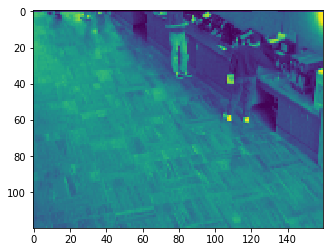

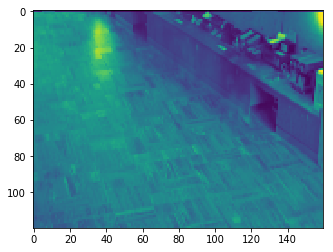

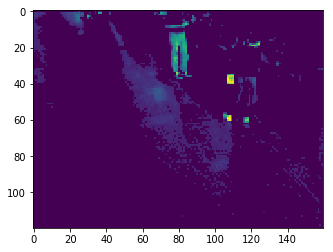

In [86]:
from sklearn.preprocessing import MinMaxScaler

n = 3039

minmax = MinMaxScaler()
res1 = res[:, n]
res1 = minmax.fit_transform(res1.reshape(-1, 1))
M1 = minmax.fit_transform(M[:, n].reshape(-1, 1))
M1 = M1.reshape(frame_size)
res1 = res1.reshape(frame_size)

final = M1
print(np.count_nonzero(final))
plt.figure()
plt.imshow(final);

final = res1
print(np.count_nonzero(final))
plt.figure()
plt.imshow(final);

final = M1 - res1
final[final < 0.06]  = 0
print(np.count_nonzero(final))
plt.figure()
plt.imshow(final);

In [ ]:
import os

def save_bmps(orig_dst, back_dst, fore_dst, M, M_rec):
    assert M.shape == M_rec.shape

    for j in range(M_rec.shape[1]):
        back_j = M_rec[:, j].reshape(120, 160)
        back_j = back_j * 255 / back_j.max()

        orig_j = M[:, j].reshape(120, 160)

        fore_j = np.maximum(0, orig_j - back_j)

        back_j = Image.fromarray(back_j.astype(np.uint8))
        back_j.save(back_dst + 'b{0:05d}.bmp'.format(j))

        fore_j = Image.fromarray(fore_j.astype(np.uint8))
        fore_j.save(fore_dst + 'b{0:05d}.bmp'.format(j))

        orig_j = Image.fromarray(orig_j.astype(np.uint8))
        orig_j.save(orig_dst + 'b{0:05d}.bmp'.format(j))

In [ ]:
back_dir = "./background/"
fore_dir = "./foreground/"
orig_dir = "./original/"

os.makedirs(back_dir, exist_ok=True)
os.makedirs(fore_dir, exist_ok=True)
os.makedirs(orig_dir, exist_ok=True)
save_bmps(orig_dir, back_dir, fore_dir, M, res)

In [ ]:
%%bash

function make_video {
    ffmpeg -framerate 60 -i $1/b0%04d.bmp -r 60 -y $1.mp4
}

for dir in Bootstrap original background foreground; do
    make_video $dir
done

In [22]:
import numpy as np
from scipy import sparse

A = np.array([[1, 2, 3], [5, 4, 7], [1, 3, 8]])
B = sparse.csr_matrix(A)

print (B.shape)

(3, 3)


In [24]:
P = sparse.csr_matrix.power(B, 2)

In [25]:
print (P)

  (0, 0)	1
  (0, 1)	4
  (0, 2)	9
  (1, 0)	25
  (1, 1)	16
  (1, 2)	49
  (2, 0)	1
  (2, 1)	9
  (2, 2)	64


In [27]:
print (np.linalg.matrix_power(B,2))

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional